![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# An introduction to DMD

This notebook introduces the basic theory behind dynamic mode decomposition (DMD). The content is heavily influenced by the following publications, which are also great resources for learning:

- [Dynamic Mode Decomposition in Python](http://www.pyrunner.com/weblog/2016/07/25/dmd-python/) by Robert Taylor
- [Data Driven Science and Engineering](https://www.cambridge.org/core/books/datadriven-science-and-engineering/77D52B171B60A496EAFE4DB662ADC36E) by Steven L. Brunton and J. Nathan Kutz
- [Dynamic Mode Decomposition](https://epubs.siam.org/doi/abs/10.1137/1.9781611974508) by J. Nathan Kutz, Steven L. Brunton, Bingni W. Brunton, and Joshua L. Proctor
- [PyDMD tutorial](https://raw.githubusercontent.com/mathLab/PyDMD/master/tutorials/tutorial_dsweb.pdf) by Niccola Demo and Marco Tezzele

## DMD at a glance

### Goal

There are three typical goals when performing a DMD analysis:

- modal analysis; in the context of fluid mechanics, modal analysis may be seen as the extraction of coherent flow structures and their associated frequencies and amplitudes
- creation of a reduced-order model (ROM)
- stability analysis; under certain conditions, particular modes might be identified as growing or shrinking over time

### Inputs

DMD is a data-driven method that requires sequential snapshot data as input. Applied to fluid flows, snapshots of the pressure or velocity field or derived quantitites are typically analyzed with DMD. Suppose we take a snapshot at time instance $t_n$ and organize it in a long column vector $\mathbf{x}_n$. The spatial arangement of points in the snapshot is ignored (of course, all column vectors must be assembled in the same order). We can then organize a time series of $N$ snapshots in two distinct data matrices:
$$
\mathbf{X} = 
 \begin{bmatrix}
   \vert & \vert &     & \vert \\
   \mathbf{x}_0  & \mathbf{x}_1   & ... & \mathbf{x}_{N-2} \\
   \vert & \vert &     & \vert
 \end{bmatrix}
$$

$$\mathbf{X}^\prime = 
 \begin{bmatrix}
   \vert & \vert &     & \vert \\
   \mathbf{x}_1  & \mathbf{x}_2   & ... & \mathbf{x}_{N-1} \\
   \vert & \vert &     & \vert
 \end{bmatrix}
$$

The second data matrix is similar to the first one but shifted by one time instance. The reason for this arrangement will become clear in the next section.

### Basic idea and theory

The DMD's main objective is to approximate a linear operator $\mathbf{A}$ that maps a snapshot from time $t_n$ to $t_{n+1}$ as:
$$
  \mathbf{x}_{n+1} = \mathbf{Ax}_n
$$
Of course, if the underlying dynamics are not perfectly linear, there won't be a single linear operator that works for all snapshot pairs, but we can approximate a best-fit linear operator using the pseudo inverse $\mathbf{X}^\dagger$:
$$
  \mathbf{A}\triangleq \mathbf{X}^\prime\mathbf{X}^\dagger
$$
Knowing the linear operator $\mathbf{A}$ allows us to make predictions beyond the time range of the snapshots by repeatedly mapping $\mathbf{x}_n$ to $\mathbf{x}_{n+1}$. If we also know the eigen decomposition of $\mathbf{A}$, namely:
$$
  \mathbf{A} = \mathbf{\Phi\Lambda\Phi}^{-1},
$$
we can derive a relatively simple equation to make future state predications at any time $t_n$ without having to make $n$ discrete steps to get there. In the equation above, $\mathbf{\Phi}$ is a matrix whose columns are the eigenvectors of $\mathbf{A}$, and $\mathbf{\Lambda}$ is a diagonal matrix with the eigenvalues of $\mathbf{A}$ forming the diagonal elements. The discrete operator $\mathbf{A}$ propagates $\mathbf{x}_n$ to $\mathbf{x}_{n+1}$. If we wanted to know $\mathbf{x}_{n+2}$, we could apply $\mathbf{A}$ twice, e.g., $\mathbf{x}_{n+2}=\mathbf{AAx}_{n}$. If we then replace $\mathbf{A}$ with its eigen decomposition and use the identity $\mathbf{\Phi\Phi}^{-1} = \mathbf{\Phi}^{-1}\mathbf{\Phi} = \mathbf{I}$, we get:
$$
  \mathbf{x}_{n+2}=\mathbf{AAx}_{n} = \mathbf{\Phi\Lambda\Phi}^{-1}\mathbf{\Phi\Lambda\Phi}^{-1}\mathbf{x}_{n} = \mathbf{\Phi\Lambda}^{2}\mathbf{\Phi}^{-1}\mathbf{x}_{n},
$$
or more in general for instance $n+k$
$$
  \mathbf{x}_{n+k} = \mathbf{\Phi\Lambda}^{k}\mathbf{\Phi}^{-1}\mathbf{x}_{n}.
$$
Now we use the expression above to re-write the equation $\mathbf{X}^\prime \approx \mathbf{AX}$ with the eigen decomposition of $\mathbf{A}$:
$$
\begin{align}
  \mathbf{X}^\prime &= \mathbf{AX} \\
  &= \mathbf{A}\left[\mathbf{x}_0, \mathbf{x}_1, ... , \mathbf{x}_{N-2} \right]\\
  &= \left[\mathbf{\Phi\Lambda}^{0}\mathbf{\Phi}^{-1}\mathbf{x}_0, \mathbf{\Phi\Lambda}^{1}\mathbf{\Phi}^{-1}\mathbf{x}_0, ... , \mathbf{\Phi\Lambda}^{N-2}\mathbf{\Phi}^{-1}\mathbf{x}_0 \right]\\
  &= \mathbf{\Phi}\left[\mathbf{\Lambda}^{0}, \mathbf{\Lambda}^{1}, ... , \mathbf{\Lambda}^{N-2}\right]\mathbf{\Phi}^{-1}\mathbf{x}_0.
\end{align}
$$
The initial state $\mathbf{x}_0$ projected onto $\mathbf{\Phi}^{-1}$ is often abbreviated as $\mathbf{b}=\mathbf{\Phi}^{-1}\mathbf{x}_0$. Then, the generic formula to predict the state vector $\mathbf{x}_n$ reads:
$$
  \mathbf{x}_n = \mathbf{\Phi\Lambda}^{n}\mathbf{b}.
$$
The same problem may be posed with a time-continuous state $\mathbf{x}=\mathbf{x}(t)$ instead of discrete one. Then the basic formulation of DMD, mapping a given state linearly into the future, becomes a system of linear ordinary differential equations (ODEs):
$$
\frac{\mathrm{d}\mathbf{x}}{\mathrm{d}t} = \mathbf{\mathcal{A}x},
$$
where $\mathbf{\mathcal{A}}$ is the continuous counterpart of $\mathbf{A}$ (the connection between both operators will be established in the following paragraphs). The initial value problem has the solution:
$$
  \mathbf{x}(t) = \mathrm{exp}\left(\mathbf{\mathcal{A}}t\right) \mathbf{x}_0,
$$
where $\mathrm{exp}\left(\mathbf{\mathcal{A}}\right)$ is the so-called [matrix exponential](https://en.wikipedia.org/wiki/Matrix_exponential) (refer to chapter 7.7 of [this book](https://www.wiley.com/en-us/Elementary+Differential+Equations+and+Boundary+Value+Problems%2C+11th+Edition-p-9781119381648) for the derivation). Why do we need the continuous formulation you may wonder. The answer is that it is much easier to assess periodicity and stability in this formulation. Say we know the eigen decomposition $\mathbf{\mathcal{A}} = \tilde{\mathbf{\Phi}}\tilde{\mathbf{\Lambda}}\tilde{\mathbf{\Phi}}^{-1}$, then we can reformulate the analytical solution as (refer to the article on matrix exponentials):
$$
  \mathbf{x}(t) = \mathrm{exp}\left(\tilde{\mathbf{\Phi}}\tilde{\mathbf{\Lambda}}\tilde{\mathbf{\Phi}}^{-1}t\right) \mathbf{x}_0 = \tilde{\mathbf{\Phi}}\mathrm{exp}\left(\tilde{\mathbf{\Lambda}}t\right)\tilde{\mathbf{\Phi}}^{-1} \mathbf{x}_0 = \tilde{\mathbf{\Phi}}\mathrm{exp}\left(\tilde{\mathbf{\Lambda}}t\right)\tilde{\mathbf{b}}.
$$
Each column of $\tilde{\mathbf{\Phi}}$ has the same dimension as a snapshot and may be interpreted as a characteristic (spatial) flow structure. The exponential term yields a diagonal matrix with time-dependent coefficients $\tilde{\lambda}_i t$, where $\tilde{\lambda}_i$ is the $i$th eigenvalue of $\mathbf{\mathcal{A}}$. If we multiply the eigenvector matrix $\tilde{\mathbf{\Phi}}$ with the matrix exponential, we are effectively multiplying the $i$th column of $\tilde{\mathbf{\Phi}}$ with $\mathrm{exp}(\tilde{\lambda}_i t)$. Therefore, the eigenvalue $\tilde{\lambda}_i$ defines the $i$th mode's temporal behavior. Specifically, we may use Euler's identity to write:
$$
\begin{align}
  \tilde{\lambda}_j &= a_i + b_i j \\
  \mathrm{exp}\left(\tilde{\lambda}_i t\right) &= \mathrm{exp}\left((a_i+b_i j) t\right)\\
  &= \mathrm{exp}\left(a_i t\right)\mathrm{exp}\left(b_i j t\right) \\
  &= \mathrm{exp}\left(a_i t\right) \left(\mathrm{cos}\left(b_i t\right)+j\mathrm{sin}\left(b_i t\right)\right),
\end{align}
$$
where $a_i = Re(\tilde{\lambda}_i)$ and $b_i = Im(\tilde{\lambda}_i)$ are the real and imaginary parts of the $i$th eigenvalue, respectively. Now we can observe the following:

- if the eigenvalue has a non-zero imaginary part $b_i$, the time behavior will be periodic
- if we express the argument of sine and cosine as $b_i t = 2\pi f_i t$, the formula for the $i$th frequency is $f_i = b_i/(2\pi)$
- for the real part $a_i$
  - if $a_i = 0$, the temporal behavior is constant or periodic with constant amplitude
  - if $a_i > 0$, the mode is growing over time
  - if $a_i < 0$, the mode is decreasing over time
- because of the points above, $a_i$ may be called the growth rate of the $i$th mode
  
Typically, we do not know $\mathbf{\mathcal{A}}$ but we have to work with discrete snapshots and the operator $\mathbf{A}$. Therefore, we need a link between the discrete and the continuous formulation, which is established by evaluating the continuous solution at times $t_n=n\Delta t$ and $t_{n+1}=(n+1)\Delta t$ to obtain $\mathbf{x}_{n}$ and $\mathbf{x}_{n+1}$, respectively:
$$
\begin{align}
  \mathbf{x}(t=n\Delta t) &= \mathrm{exp}\left(\mathbf{\mathcal{A}}n\Delta t\right)\mathbf{x}_0 \\
  \mathbf{x}(t=(n+1)\Delta t) &= \mathrm{exp}\left(\mathbf{\mathcal{A}}(n+1)\Delta t\right)\mathbf{x}_0 \\
  &= \mathrm{exp}\left(\mathbf{\mathcal{A}}\Delta t\right) \mathrm{exp}\left(\mathbf{\mathcal{A}}n \Delta t\right) \mathbf{x}_0\\
  \mathbf{x}_{n+1} &= \underbrace{\mathrm{exp}\left(\mathbf{\mathcal{A}}\Delta t\right)}_{\mathbf{A}}\mathbf{x}_n \\
  \mathbf{x}_{n+1} &= \mathbf{Ax}_n
\end{align}
$$
By comparing the eigen decomposition of $\mathbf{\mathcal{A}}$ and $\mathbf{A}$, we notice that the eigenvectors are identical, i.e., $\mathbf{\Phi} = \tilde{\mathbf{\Phi}}$. The eigenvalues are related by the relation:
$$
  \mathbf{\Lambda} = \mathrm{exp}\left(\tilde{\mathbf{\Lambda}}\Delta t\right).
$$
Summarizing the paragraphs above, we have learned:

- the linear operator $\mathbf{A}$ maps a given state by $\Delta t$ into the future
- the operator's eigenvectors (DMD modes) may represent characteristic spatial flow patterns
- the operator's eigenvalues define the modes' temporal behavior in terms of growth and periodicity
- the $\mathbf{b}$ vector represents a constant weight for each DMD mode; therefore, we may consider the coefficients of $\mathbf{b}$ as mode amplitudes

For fluid mechanical problems in particular, there is a pratical issue with the theory described above. If a snapshot consists of $M$ points, then $\mathbf{A}$ is an $M\times M$ dense matrix. If $M=10^4$, the resulting operator would require about 0.75GB of memory (double precision). Increasing the number of points to $M=10^5$ yields a 74.5GB operator, which is already impractical for most applications. The next section details some numerical tricks to overcome this problem.

### Steps to compute the DMD in practice

**1. Compute the SVD of $\mathbf{X}$**

First, we factorize the data matrix $\mathbf{X}$ into its singular value decomposition (SVD):
$$
  \mathbf{X} = \mathbf{U\Sigma V}^{\dagger},
$$
where $\mathbf{U}$ is a $M\times M$ unitary matrix, $\mathbf{\Sigma}$ is a $M\times N$ matrix containing a smaller diagonal matrix of singular values, and $\mathbf{V}$ is a $N\times N$ unitary matrix (refer to the [Linear algebra with PyTorch](linear_algebra_basics.ipynb) notebook). What the SVD essentially provides us with is an easily controllable means to perform matrix approximations and a potentially better coordinate system to represent the system's dynamics.

**2. Compute a reduced linear operator**

As mentioned above, we can approximate the discrete linear operator as:
$$
  \mathbf{A}\triangleq \mathbf{X}^\prime \mathbf{X}^\dagger = \mathbf{X}^\prime \mathbf{V\Sigma}^{-1}\mathbf{U}^\dagger.
$$
However, to reduce the computational effort, we first represent $\mathbf{A}$ in the span of the first $r$ left singular vectors $\mathbf{U}_r$, where $0<r\le N$:
$$
  \tilde{\mathbf{A}} = \mathbf{U}_r^\dagger \mathbf{AU}_r,
$$
where $\tilde{\mathbf{A}}$ is an $r\times r$ square matrix that is [similar](ttps://en.wikipedia.org/wiki/Matrix_similarity) to $\mathbf{A}$. Note that this projection is only meaningful if $\mathbf{X}$ and $\mathbf{X}^\prime$ do not have full rank, e.g., if there exist coherent structures in the flow. Combining the two expressions above and using the rank $r$ approximation of the SVD yields:
$$
  \tilde{\mathbf{A}} = \mathbf{U}_r^\dagger\mathbf{X}^\prime\mathbf{V}_r\mathbf{\Sigma}_r^{-1}\mathbf{U}_r^\dagger\mathbf{U}_r = \mathbf{U}_r^\dagger\mathbf{X}^\prime\mathbf{V}_r\mathbf{\Sigma}_r^{-1}.
$$
It is important to mention that $\mathbf{U}_r^\dagger\mathbf{U}_r$ yields an $r\times r$ identity matrix, whereas $\mathbf{U}_r\mathbf{U}_r^\dagger$ in general **does not** yield a $M\times M$ identity matrix. After completing this second step, the reduced $r\times r$ operator $\tilde{\mathbf{A}}$ is much easier to deal with.

**3. Compute the eigen decomposition of the reduced linear operator**

If $\mathbf{A}$ is not of full rank and lies in the span of the first $r$ singular vectors, $\tilde{\mathbf{A}}$ and $\mathbf{A}$ are [similar](https://en.wikipedia.org/wiki/Matrix_similarity) and, therefore, have the same non-zero eigenvalues. If $r\ll M$ the following eigenvalue problem is much easier to solve:
$$
  \tilde{\mathbf{A}}\mathbf{W} =\mathbf{W\Lambda}
$$
The rank reduction may also introduce an error in the computed eigenvalues.

**4. Compute the eigenvectors of the original linear operator**

The final piece of the puzzle is the computation to obtain the original operator's eigenvectors $\mathbf{\Phi}$. In the [original article introducing the DMD](https://hal-polytechnique.archives-ouvertes.fr/file/index/docid/1020654/filename/DMS0022112010001217a.pdf) by Peter Schmid, the eigenvalues of $\mathbf{A}$ are recovered by computing:
$$
  \tilde{\mathbf{\Phi}} = \mathbf{U}_r\mathbf{W}
$$
However, if we try to transform the reduced eigenvalue problem into eigenvalue problem of $\mathbf{A}$, we find:
$$
\begin{align}
  \tilde{\mathbf{A}}\mathbf{W} &= \mathbf{W\Lambda} \\
  \mathbf{U}_r\underbrace{\mathbf{U}_r^\dagger\mathbf{AU}_r}_{\tilde{\mathbf{A}}}\mathbf{W} &= \mathbf{U}_r\mathbf{W\Lambda} \\
  \underbrace{\mathbf{U}_r\mathbf{U}_r^\dagger}_{\neq \mathbf{I}} \mathbf{A}\tilde{\mathbf{\Phi}} &= \tilde{\mathbf{\Phi}}\mathbf{\Lambda}
\end{align}
$$
A more widely accepted definition suggested by [Jonathan Tu et al.](https://arxiv.org/pdf/1312.0041.pdf) is:
$$
  \mathbf{\Phi} = \mathbf{X}^\prime\mathbf{V}_r\mathbf{\Sigma}_r^{-1}\mathbf{W}.
$$
Multiplying both sides of the reduced eigenvalue problem with $\mathbf{X}^\prime\mathbf{V}_r\mathbf{\Sigma}_r^{-1}$ yields:
$$
\begin{align}
  \tilde{\mathbf{A}}\mathbf{W} &= \mathbf{W\Lambda} \\
  \mathbf{X}^\prime\mathbf{V}_r\mathbf{\Sigma}_r^{-1} \underbrace{\mathbf{U}_r^\dagger\mathbf{X}^\prime\mathbf{V}_r\mathbf{\Sigma}_r^{-1}}_{\tilde{\mathbf{A}}} \mathbf{W}&= \mathbf{X}^\prime\mathbf{V}_r\mathbf{\Sigma}_r^{-1}\mathbf{W\Lambda} \\
  \mathbf{A}\mathbf{X}^\prime\mathbf{V}_r\mathbf{\Sigma}_r^{-1}\mathbf{W}&= \mathbf{X}^\prime\mathbf{V}_r\mathbf{\Sigma}_r^{-1}\mathbf{W\Lambda} \\
  \mathbf{A\Phi} &= \mathbf{\Phi\Lambda}
\end{align}
$$
Therefore, the computation suggested by Jonathan Tu et al. yields the so-called **exact DMD modes**. The modes obtained using the original definition are commonly called **projected DMD modes** because the relation between both eigenvector matrices is $\tilde{\mathbf{\Phi}} = \mathbf{U}_r\mathbf{U}_r^\dagger\mathbf{\Phi}$ (we obtain $\tilde{\mathbf{\Phi}}$ by projecting $\mathbf{\Phi}$ onto the POD modes/left singular vectors of $\mathbf{X}$). However, if the last column of $\mathbf{X}^\prime$ is in the span of $\mathbf{X}$, both definitions yield the same result; refer to remark 5 of the article by J. Tu et al. linked above.

## A simple example

In the following, we'll create a simple dataset and implement a basic version of the DMD from scratch in PyTorch.

### Generating the dataset

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch as pt

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160

The problem we are examining has two independent variables: the time $t$ and the spatial coordinate $x$. We start by creating a spatio-temporal grid to create our test data.

In [2]:
x = pt.linspace(-10, 10, 50)
t = pt.linspace(0, 6*np.pi, 40)
X, T = pt.meshgrid(x, t)

Now we evaluate several periodic functions on the grid. There are several ways to visualize the temporal evolution of the 1D profiles (one spatial coordinate), of which we explore two in this notebook. In the first variant, we plot the spatial distribution at fixed time intervals as a line plot. To introduce the notion of time, the lines' opacity decreases as the time increases. Moreover, we allow to plot optionally both real and imaginary part.

The first function comprises two oscillating hyperbolic functions:

$$
  f_1 = 10\mathrm{tanh}(x/2)\mathrm{cosh}(x/2)e^{(0.1+2.8j)t}
$$

The positive real part in the exponent gives the oscillation a slowly growing amplitude. The second function is an oscillating parabola:

$$
  f_2 = (20-x^2/5)e^{(-0.05+2.3j)t}
$$

In comparison to $f_1$, this function has a **decreasing** amplitude and oscillates at a slightly smaller frequency (smaller imaginary part). The third function is an oscillating line (like a seesaw):

$$
  f_3 = x e^{0.6j t}
$$

This time, the oscillation's amplitude remains constant. In comparison to the other two functions, $f_3$ oscillates at the lowest frequency.

In [3]:
def plot_as_line(data, x, t, every, show_imag=False):
    fig, ax = plt.subplots(figsize=(8, 3))
    t_selected = t[::every]
    data_selected = data[:, ::every]
    opacity_factor = 0.5
    for i in range(len(t_selected)):
        if i == 0:
            ax.plot(x, data[:, i].real, c="C0", alpha=1/(1+i*opacity_factor), ls="-", label=r"$Re(f)$")
            if show_imag:
                ax.plot(x, data[:, i].imag, c="C1", alpha=1/(1+i*opacity_factor), ls="--", label=r"$Im(f)$")
        else:
            ax.plot(x, data[:, i].real, c="C0", alpha=1/(1+i*opacity_factor), ls="-")
            if show_imag:
                ax.plot(x, data[:, i].imag, c="C1", alpha=1/(1+i*opacity_factor), ls="--")
    ax.set_xlim(-10, 10)
    ax.set_xlabel(r"$x$")
    ax.legend()
    ax.set_title("time progression indicated by decreasing opacity")

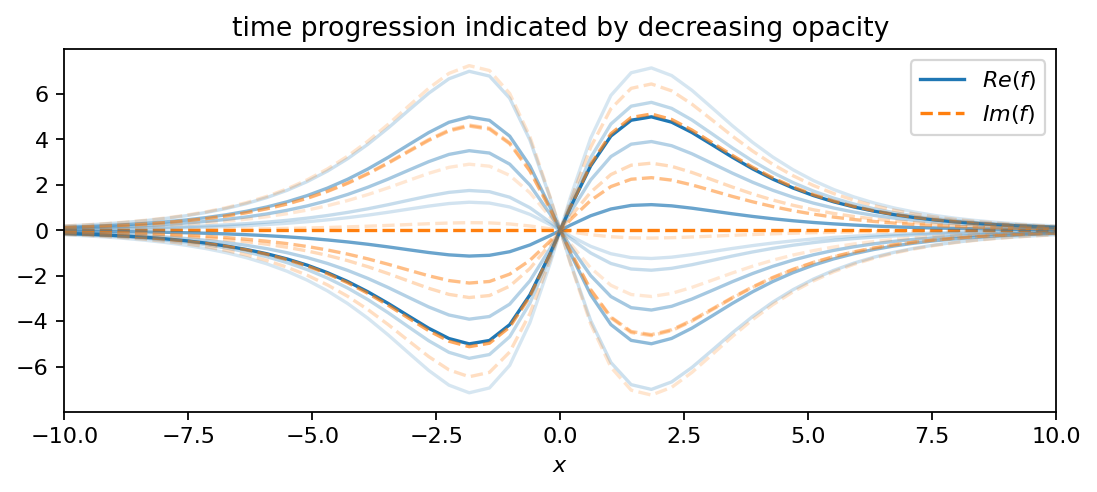

In [4]:
f1 = pt.multiply(10.0*pt.tanh(X/2.0)/pt.cosh(X/2.0), pt.exp((0.1+2.8j)*T))
plot_as_line(f1, x, t, 4, True)

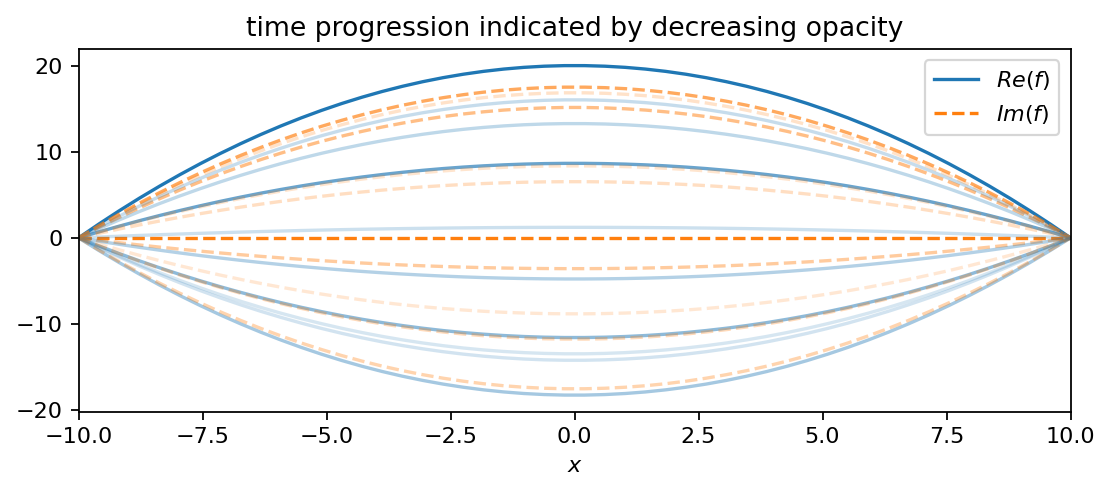

In [5]:
f2 = pt.multiply(20-0.2*pt.pow(X, 2), pt.exp((-0.05+2.3j)*T))
plot_as_line(f2, x, t, 4, True)

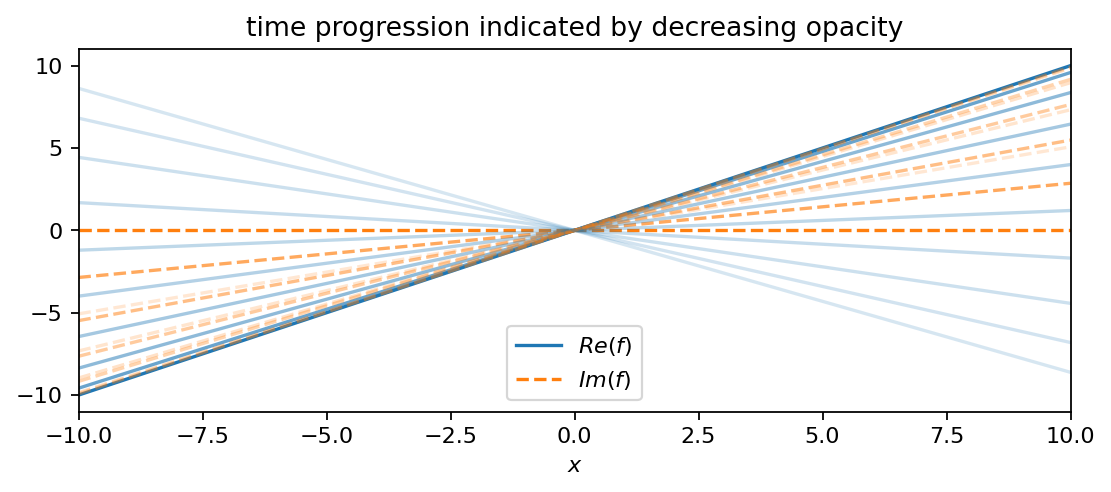

In [6]:
f3 = pt.multiply(X, pt.exp(0.6j*T))
plot_as_line(f3, x, t, 4, True)

The following plot shows a superposition of all three functions, which comprises our DMD dataset. Even though simple functions were used to create the dataset, it is not straight forward any more to infer the individual contributions visually. Our goal is to isolate the individual frequencies and growth rates from the data and to compare those values to the ones used to generate the data.

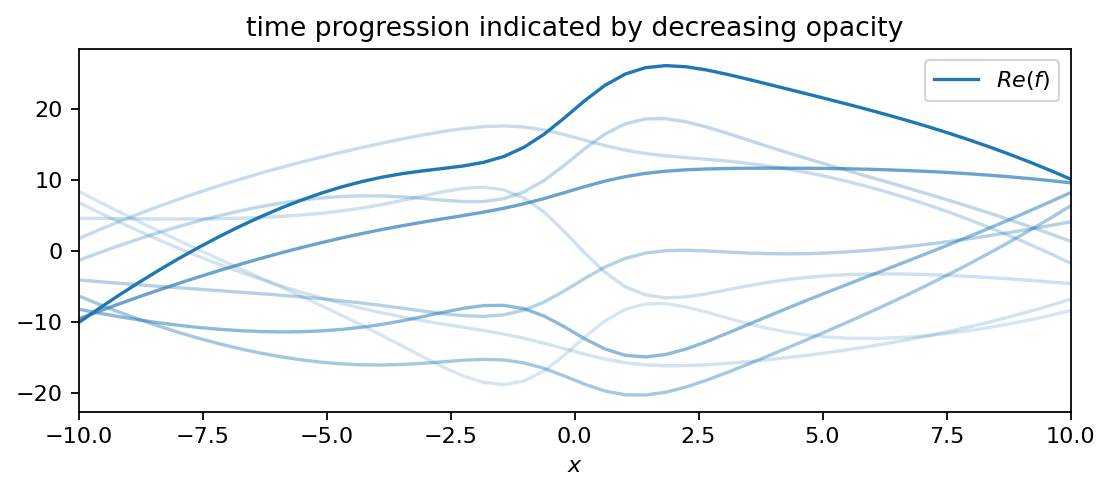

In [7]:
data = f1 + f2 + f3
plot_as_line(data, x, t, 4)

Before we get to the DMD, let's try a second approach to visualize the dataset. This time, we roll out the temporal evolution and show the full dataset as image. The function's value is indicated by color (yellow for high and blue for low values). To make the analysis more challening, we generate a second dataset that is corrupted by noise. The noise is sampled from a Gaussian distribution with non-zero mean, which introduces some bias.

In [8]:
def show_as_image(data, X, T):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    ax1.pcolormesh(T.T, X.T, data.T.real, shading="nearest")
    ax2.pcolormesh(T.T, X.T, data.T.imag, shading="nearest")
    ax1.set_xlabel(r"$t$")
    ax2.set_xlabel(r"$t$")
    ax1.set_ylabel(r"$x$")
    ax1.set_title(r"$Re(f)$")
    ax2.set_title(r"$Im(f)$")

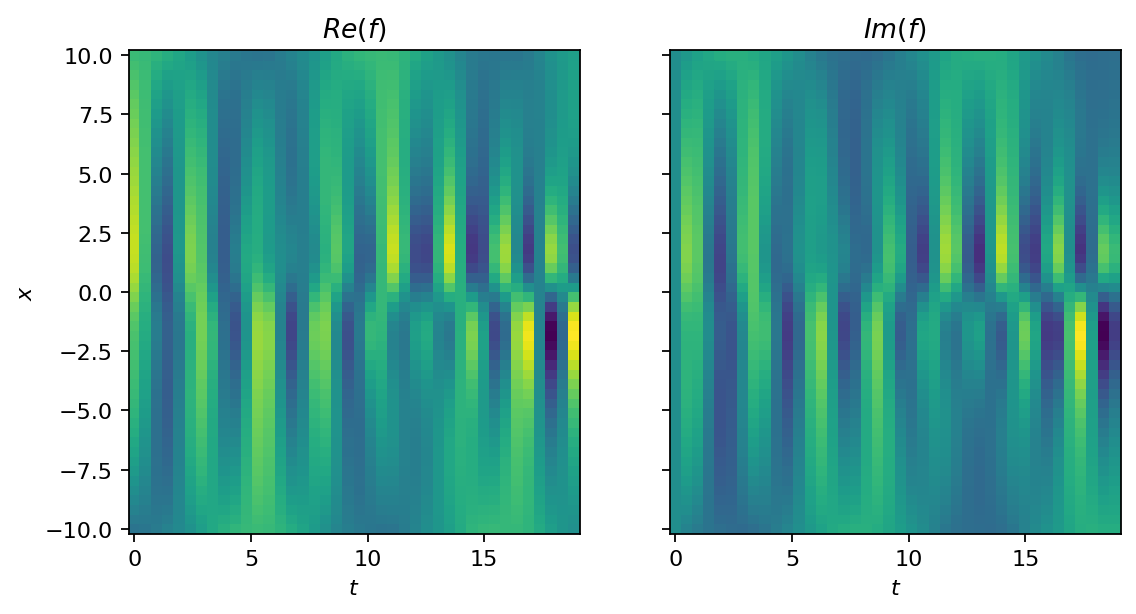

In [9]:
show_as_image(data, X, T)

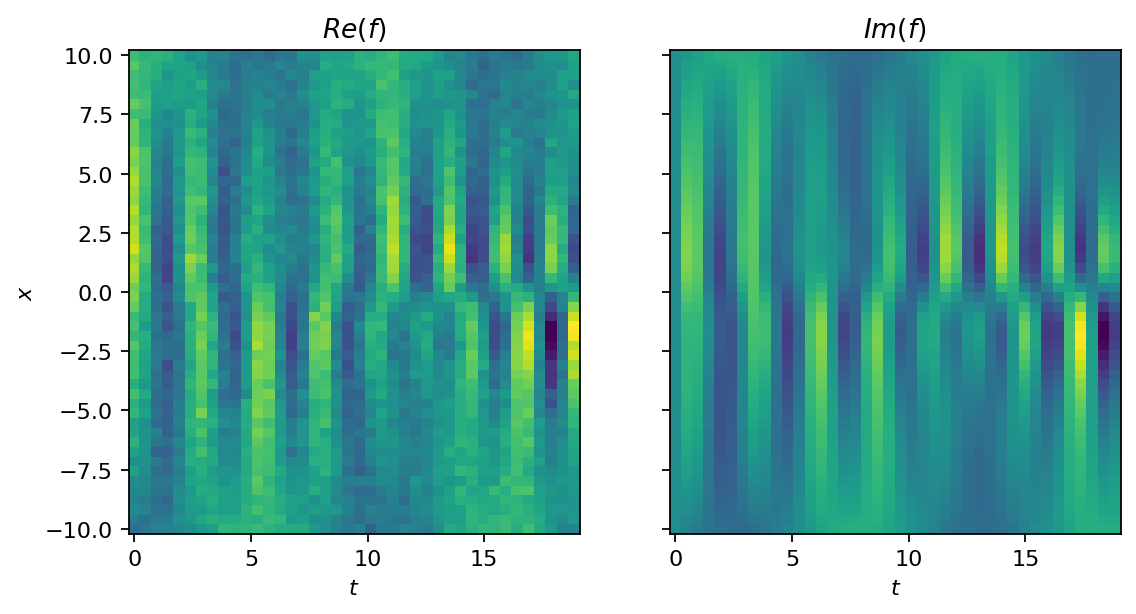

In [10]:
data_noisy = data + pt.normal(2*pt.ones_like(X), 2*pt.ones_like(X))
show_as_image(data_noisy, X, T)

### Singular Value Decomposition (SVD)

The first step of the DMD consists of computing the SVD of the $\mathbf{X}$ matrix. Our dataset is already organized in the right way with the snapshots forming the columns of the data matrix. We compute the SVD on both the default and the noisy datasets. Note that instead of creating two data matrices $\mathbf{X}$ and $\mathbf{X}^\prime$, we work with slicing; refer to [this notebook](linear_algebra_basics.ipynb) for more information on slicing tensors.

In [11]:
U, s, VH = pt.linalg.svd(data[:, :-1])
Un, sn, VHn = pt.linalg.svd(data_noisy[:, :-1])

In the original dataset, three non-zero singular values are identified. Adding noise yields many more singular values with smaller but non-zero values. Also the largest singular value differs slightly from that of the clean data.

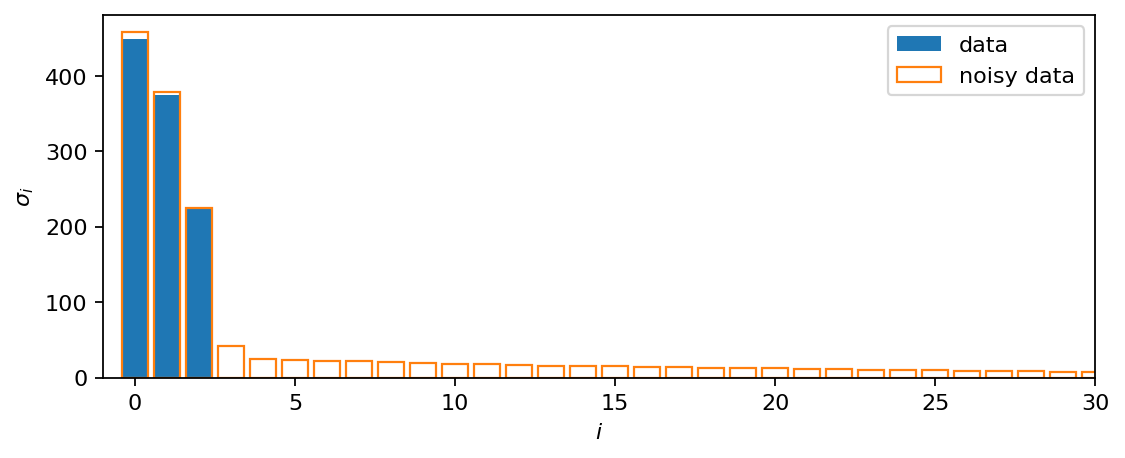

In [12]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.bar(range(s.size()[0]), s, color="C0", label="data")
ax.bar(range(sn.size()[0]), sn, ec="C1", fill=False, label="noisy data")
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$\sigma_i$")
ax.set_xlim(-1, 30)
ax.legend()
plt.show()

### Truncating

Truncation is an essential step of the DMD to reduce the computational effort but also to remove potential noise from the data. Here, we know the true rank of the data matrix, which is in general not the case. When working with real datasets, one can determine a suitable truncation by trial and error or by using some other criterion as demonstrated in the [this example](svd_ht.ipynb). 

In [13]:
rank = 3
Ur, sr, Vr = U[:, :rank], s[:rank], VH.conj().T[:, :rank]
Unr, snr, Vnr = Un[:, :rank], sn[:rank], VHn.conj().T[:, :rank]

### Eigen decomposition

Next, we compute the reduced linear operator $\tilde{\mathbf{A}}$ using the time-shifted matrix $\mathbf{X}^\prime$ and the truncated SVD.

In [14]:
At = Ur.conj().T @ data[:, 1:] @ Vr @ pt.diag(1.0/sr).type(pt.cfloat)
Atn = Unr.conj().T @ data[:, 1:] @ Vnr @ pt.diag(1.0/snr).type(pt.cfloat)

The real and imaginary parts of the operator's eigenvalues tell us about the time-dynamics of individual modes. First, we plot the eigenvalues in the imaginary plane together with a unit-circle. Note that for the time-discrete system, the modes are:

- stable if the eigenvalues are on the circle
- growing (unstable) if the eigenvalues are outside the circle
- shrinking (stable) if the eigenvalues are inside the circle

As can be seen in the image below, the dynamics of all three components are identified correctly. The noise introduces some error. However, thanks to the truncation, we already removed a significant portion of the noise, and the identified dynamics remain close to the ground truth.

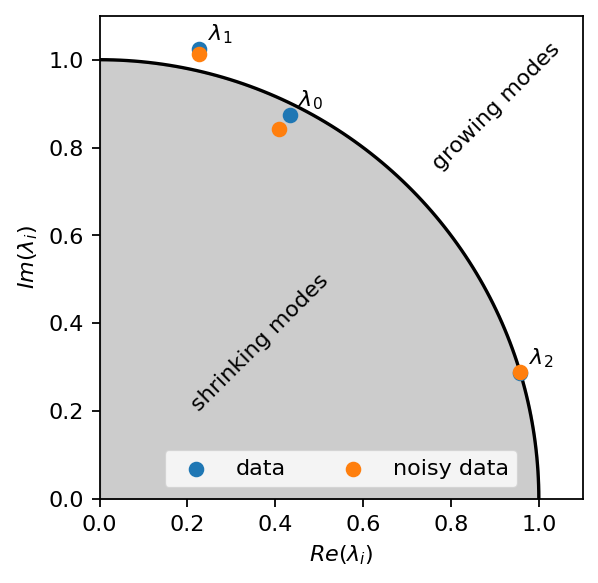

In [15]:
val, vec = pt.linalg.eig(At)
valn, vecn = pt.linalg.eig(Atn)

p = pt.linspace(0, np.pi/2, 100)

fig, ax = plt.subplots()
ax.plot(pt.cos(p), pt.sin(p), c="k")
ax.fill_between(pt.cos(p),0, pt.sin(p), color="k", alpha=0.2)
ax.scatter(val.real, val.imag, label="data", zorder=6)
ax.scatter(valn.real, valn.imag, label="noisy data", zorder=6)
for i, ev in enumerate(val):
    ax.text(ev.real+0.02, ev.imag+0.02, r"$\lambda_{:d}$".format(i))
ax.text(0.2, 0.2, "shrinking modes", rotation=45)
ax.text(0.75, 0.75, "growing modes", rotation=45)
ax.set_aspect("equal")
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.set_xlabel(r"$Re(\lambda_i)$")
ax.set_ylabel(r"$Im(\lambda_i)$")
ax.legend(loc=8, ncol=2)
plt.show()

Let's now compute the eigenvalues of the corresponding continuous linear operator. From the real and imaginary parts of all $\tilde{\lambda}_i$, we can directly read off growth rates and frequencies.

In [16]:
dt = t[1] - t[0]
lambda_t = pt.log(val) / dt
lambdan_t = pt.log(valn) / dt
print("clean dataset")
for i, l in enumerate(lambda_t):
    print(r"Mode {:d} has a growth rate of {:+2.3f} and oscillates with a frequency of {:2.3f}/(2π)Hz.".format(i, l.real, l.imag))
print("\nnoisy dataset")
for i, l in enumerate(lambdan_t):
    print(r"Mode {:d} has a growth rate of {:+2.3f} and oscillates with a frequency of {:2.3f}/(2π)Hz.".format(i, l.real, l.imag))

clean dataset
Mode 0 has a growth rate of -0.050 and oscillates with a frequency of 2.300/(2π)Hz.
Mode 1 has a growth rate of +0.100 and oscillates with a frequency of 2.800/(2π)Hz.
Mode 2 has a growth rate of -0.000 and oscillates with a frequency of 0.600/(2π)Hz.

noisy dataset
Mode 0 has a growth rate of -0.134 and oscillates with a frequency of 2.315/(2π)Hz.
Mode 1 has a growth rate of +0.075 and oscillates with a frequency of 2.796/(2π)Hz.
Mode 2 has a growth rate of -0.002 and oscillates with a frequency of 0.605/(2π)Hz.


With the clean dataset as input, DMD perfectly identifies growth rates and frequencies of the underlying functions used to create the dataset. The noise corrupts the values slightly, but the results remain meaningful, too.

### DMD modes

In the final part of this notebook, we reconstruct the eigenvectors of the full linear operator, the so-called DMD modes, and visualize the difference between projected and exact DMD modes.

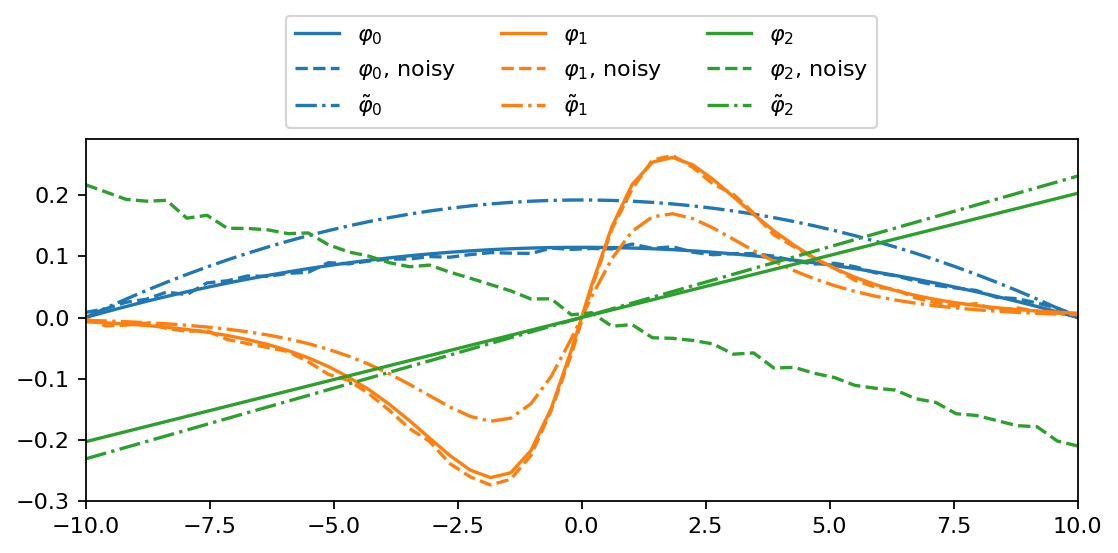

In [17]:
phi = data[:, 1:] @ Vr @ pt.diag(1.0/sr).type(pt.cfloat) @ vec
phin = data_noisy[:, 1:] @ Vnr @ pt.diag(1.0/snr).type(pt.cfloat) @ vecn
phi_pro = Ur @ vec

fig, ax = plt.subplots(figsize=(8, 3))
colors = ["C{:1d}".format(i) for i in range(3)]
for i in range(rank):
    ax.plot(x, phi[:, i].real, c=colors[i], ls="-", label=r"$\varphi_{:d}$".format(i))
    ax.plot(x, phin[:, i].real, c=colors[i], ls="--", label=r"$\varphi_{:d}$, noisy".format(i))
    ax.plot(x, phi_pro[:, i].real, c=colors[i], ls="-.", label=r"$\tilde{\varphi}" + r"_{:d}$".format(i))
ax.set_xlim(-10, 10)
ax.legend(bbox_to_anchor=(0.5, 1.0), loc=8, ncol=3)
plt.show()

Each mode characterizes the shape of the corresponding input function very well. The noise is still visible but the reconstructed modes are close to the reference. The projected DMD modes look qualitatively similar to their exact counterparts but are not identical for the present dataset.

The first version of this notebook was created by **Jannis Anderson** during his time as student assisant at TU Braunschweig's [Institute of Fluid Mechanics](https://www.tu-braunschweig.de/ism).